In [24]:
import pickle
import csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
import random
import h5py
import bcolz as bc
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [14]:
%matplotlib inline
random.seed(98767890)

In [3]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    # input_shape = (batch, spatial_dim1, spatial_dim2, spatial_dim3, channels)
#     model.add(Convolution3D(filters,
#                             kernel_size,
#                             strides=(1, 1, 1),
#                             padding='valid',
#                             data_format=None,
#                             dilation_rate=(1, 1, 1),
#                             activation=None,
#                             use_bias=True,
#                             kernel_initializer='glorot_uniform',
#                             bias_initializer='zeros',
#                             kernel_regularizer=None,
#                             bias_regularizer=None,
#                             activity_regularizer=None,
#                             kernel_constraint=None,
#                             bias_constraint=None
#                            )
#              )

    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(16, 16, 16, 36),
                     padding='same',
                     activation='relu',
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='same'))
    
    # 2nd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(1, 1, 1),
                           padding='same'))
    
    # 3rd layer group
    model.add(Conv3D(filters=256,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(1, 1, 1),
                           padding='valid'))
    
    # 4th layer group
    model.add(Conv3D(filters=512,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=(1, 1, 1),
                           padding='valid'))
    
    # Reduce the number of parameters (!!!)
    model.add(AveragePooling3D(pool_size=(2, 2, 2), 
                               padding='valid'))
                           
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [4]:
def read_data(valid_split=0.1, test_split=0.1):
    with open('data_x_norm.pickle', 'rb') as f:
        data_x = pickle.load(f)
    with open('data_y.pickle', 'rb') as f:
        data_y = pickle.load(f)
    assert(data_x.shape[0] == data_y.shape[0]), \
    'Number of feature vectors and the corresponding labels are not the same!'
    
    valid_size = round(data_x.shape[0]*0.1)
    test_size = round(data_x.shape[0]*0.1)
    
    # Get the validation data
    rand_keys = np.random.choice(data_x.shape[0], valid_size)
    valid_x = data_x[rand_keys]
    valid_y = data_y[rand_keys]
    
    # remove validation set from the data
    mask = np.ones(data_x.shape[0], dtype=bool)
    mask[rand_keys] = False
    data_x = data_x[mask]
    data_y = data_y[mask]
    
    # Get the test data
    rand_keys = np.random.choice(data_x.shape[0], test_size)
    test_x = data_x[rand_keys]
    test_y = data_y[rand_keys]
    
    # remove test set from the data
    mask = np.ones(data_x.shape[0], dtype=bool)
    mask[rand_keys] = False
    data_x = data_x[mask]
    data_y = data_y[mask]
    
    return (data_x, data_y), (test_x, test_y), (valid_x, valid_y)

In [5]:
train, test, valid = read_data()
print(train[0].shape, train[1].shape, test[0].shape, test[1].shape, valid[0].shape, valid[1].shape)

(3308, 16, 16, 16, 36) (3308,) (408, 16, 16, 16, 36) (408,) (408, 16, 16, 16, 36) (408,)


In [6]:
# Batch generator for training
def generator(data, batch_size):
    x = data[0]
    y = data[1]
    assert(batch_size <= x.shape[0]), 'Batch size is larger than the total sample count'
    batch_x = np.zeros([batch_size] + list(x.shape[1:]))
    batch_y = np.zeros(batch_size)
    while(True):
        rand_keys = np.random.choice(x.shape[0], batch_size)
        yield x[rand_keys], y[rand_keys]

In [7]:
# Warm up the generator
bx, by = next(generator(test, 5))
bx.shape, by.shape

((5, 16, 16, 16, 36), (5,))

In [8]:
# Set dynamic memory allocation in a specific gpu
# K.clear_session()
# config = K.tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.visible_device_list = "6"
# K.set_session(K.tf.Session(config=config))

In [9]:
model = get_model(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 16, 16, 64)    62272     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 64)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 128)      221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 8, 8, 128)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 6, 6, 256)      884992    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 5, 5, 256)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 3, 3, 3, 512)      3539456   
__________

In [10]:
model = multi_gpu_model(model, gpus=8)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [11]:
batch_size = 32
epochs = 100
data_size = train[0].shape[0]
history = model.fit_generator(generator=generator(data=train, batch_size=batch_size), 
                              validation_data=(valid[0], valid[1]),
                              epochs = epochs,
                              steps_per_epoch=data_size//batch_size,
                              use_multiprocessing=True, shuffle=True,
                              verbose = 1)

Epoch 1/100
103/103 [==============================] - 18s 175ms/step - loss: 17.6287 - mean_squared_error: 17.6287 - val_loss: 4.4346 - val_mean_squared_error: 4.4346
Epoch 2/100
103/103 [==============================] - 9s 88ms/step - loss: 9.6855 - mean_squared_error: 9.6855 - val_loss: 6.0365 - val_mean_squared_error: 6.0365
Epoch 3/100
103/103 [==============================] - 9s 91ms/step - loss: 8.3074 - mean_squared_error: 8.3074 - val_loss: 3.9396 - val_mean_squared_error: 3.9396
Epoch 4/100
103/103 [==============================] - 9s 91ms/step - loss: 7.3827 - mean_squared_error: 7.3827 - val_loss: 4.1103 - val_mean_squared_error: 4.1103
Epoch 5/100
103/103 [==============================] - 9s 89ms/step - loss: 7.0838 - mean_squared_error: 7.0838 - val_loss: 3.7199 - val_mean_squared_error: 3.7199
Epoch 6/100
103/103 [==============================] - 9s 90ms/step - loss: 6.2877 - mean_squared_error: 6.2877 - val_loss: 4.4099 - val_mean_squared_error: 4.4099
Epoch 7/100


Epoch 51/100
103/103 [==============================] - 9s 86ms/step - loss: 1.9989 - mean_squared_error: 1.9989 - val_loss: 3.6616 - val_mean_squared_error: 3.6616
Epoch 52/100
103/103 [==============================] - 9s 87ms/step - loss: 2.0092 - mean_squared_error: 2.0092 - val_loss: 3.9950 - val_mean_squared_error: 3.9950
Epoch 53/100
103/103 [==============================] - 9s 87ms/step - loss: 1.9191 - mean_squared_error: 1.9191 - val_loss: 3.6576 - val_mean_squared_error: 3.6576
Epoch 54/100
103/103 [==============================] - 9s 86ms/step - loss: 1.8735 - mean_squared_error: 1.8735 - val_loss: 4.5272 - val_mean_squared_error: 4.5272
Epoch 55/100
103/103 [==============================] - 9s 87ms/step - loss: 1.7569 - mean_squared_error: 1.7569 - val_loss: 3.7198 - val_mean_squared_error: 3.7198
Epoch 56/100
103/103 [==============================] - 9s 86ms/step - loss: 1.6409 - mean_squared_error: 1.6409 - val_loss: 3.2799 - val_mean_squared_error: 3.2799
Epoch 57/1

103/103 [==============================] - 9s 86ms/step - loss: 0.8558 - mean_squared_error: 0.8558 - val_loss: 3.0359 - val_mean_squared_error: 3.0359


In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'val_mean_squared_error', 'mean_squared_error'])

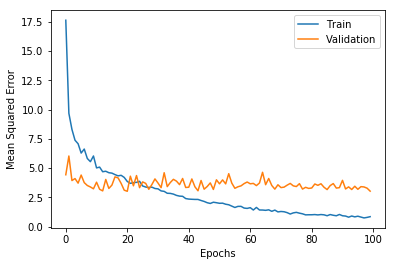

In [20]:
f = plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(['Train', 'Validation'])
plt.show()
f.savefig('training_curve.png')

In [22]:
test_pred = model.predict(x=test[0])

In [25]:
r2 = r2_score(y_pred=test_pred, y_true=test[1])
print('R2 for test data: ', r2)

R2 for test data:  0.15340728210535026


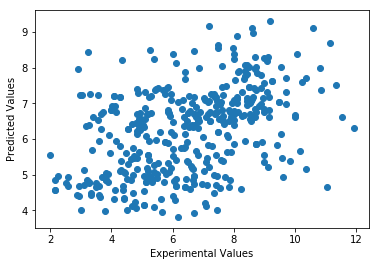

In [27]:
plt.figure()
plt.scatter(test[1], test_pred)
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.show()

In [12]:
# serialize model to JSON
model_json = get_model().to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cnn_model.h5")
print("Saved model to disk")

Saved model to disk
